In [1]:
import sys

if True:
    # !pip install -U "jax[cuda12]"
    !pip install jaxkan --no-deps
    !pip install tqdm

if True:
    """
    import os
    os.environ['XLA_FLAGS'] = (
        '--xla_gpu_enable_triton_softmax_fusion=true '
        '--xla_gpu_triton_gemm_any=True '
        '--xla_gpu_enable_async_collectives=true '
        '--xla_gpu_enable_latency_hiding_scheduler=true '
        '--xla_gpu_enable_highest_priority_async_stream=true '
    )
    """
    sys.path.append('/kaggle/input/utilspikan')

from flax import linen as nn
from flax.training import train_state
from flax.linen.initializers import glorot_normal
from typing import Callable

import jax
import jax.numpy as jnp
import numpy as np
import optax

from jaxkan.models.KAN import KAN

from tqdm import tqdm
import matplotlib.pyplot as plt

from Utils import *

jax.devices()

[CpuDevice(id=0)]

In [2]:
class Config:
    N_INPUT = 2
    X_MIN = -1
    X_MAX = 1
    
    Y_MIN = -1
    Y_MAX = 1
    
    HIDDEN_UNITS = 256

    BS = 2**12 #14
    BS_BC = 1024
    EPOCHS = round(0.25*10000) # 2 * 10000
    layer_dims = [N_INPUT, 6, 6, 1]
    
r = KeyHandler(0)

In [3]:
def get_pde_Helmholtz(model):
    @jax.jit
    def pde_loss_fn(params, collocs, state):
        def u(vec_x):
            y = model.apply(variables, vec_x)
            return y
        variables = {'params' : params}
        
        y = u(collocs)
        u_xx = gradf(u, 0, 2)(collocs)
        u_yy = gradf(u, 1, 2)(collocs)
        
        f = (1-17*jnp.pi**2)*jnp.sin(jnp.pi*collocs[:, 0])*jnp.sin(4*jnp.pi*collocs[:, 1])
        f = f.reshape(-1,1)
        
        D = 1
        pde_residual = u_xx + u_yy + y - f
        
        return pde_residual

    return pde_loss_fn

def get_adaptive_loss(model, pde_loss_fn):
    @jax.jit
    def adaptive_loss(params, collocs, bc_collocs, bc_data, state, loc_w):
        def u(vec_x):
            y = model.apply(variables, vec_x)
            return y
        variables = {'params' : params}

        new_loc_w = []

        eta = jnp.array(0.0001, dtype=float)

        pde_residues = pde_loss_fn(params, collocs, state)
        abs_res = jnp.abs(pde_residues)
        loc_w_pde = ((jnp.array(1.0)-eta)*loc_w[0]) + ((eta*abs_res)/jnp.max(abs_res))

        pde_loss = jnp.mean((pde_residues*loc_w_pde)**2)
        new_loc_w.append(loc_w_pde)
        
        bc_loss = 0
        for idx, bc_colloc in enumerate(bc_collocs):
            bc_residues = u(bc_colloc) - bc_data[idx]
            abs_res = jnp.abs(bc_residues)
            loc_w_bc = ((jnp.array(1.0)-eta)*loc_w[idx+1]) + ((eta*abs_res)/jnp.max(abs_res))
           
            bc_loss += jnp.mean((bc_residues*loc_w_bc)**2) 
            new_loc_w.append(loc_w_bc)
            
        loss = bc_loss + 0.01*pde_loss
        
        return loss, new_loc_w

    return adaptive_loss

def get_vanilla_loss(model, pde_loss_fn):
    @jax.jit
    def vanilla_loss(params, collocs, bc_collocs, bc_data, state, new_loc_w):
        def u(vec_x):
            y = model.apply(variables, vec_x)
            return y
        variables = {'params' : params}
        
        pde_residual = pde_loss_fn(params, collocs, state)
        
        bc_loss = 0
        for (bc_x, bc_y) in zip(bc_collocs, bc_data):
            bc_loss += jnp.mean((u(bc_x) - bc_y)**2)
        
        loss = jnp.mean(pde_residual**2) + bc_loss
        return loss, new_loc_w

    return vanilla_loss
    
def get_train_step(model, optimizer, loss_fn):
    @jax.jit
    def train_step(params, collocs, bc_collocs, bc_data, opt_state, state, loc_w):
        # Compute gradients and loss
        grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
        (loss, new_loc_w), grads = grad_fn(params, collocs, bc_collocs, bc_data, state, loc_w)

        # Update parameters using optimizer
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)

        return params, opt_state, loss, new_loc_w

    return train_step

class FourierFeats(nn.Module):
    num_output: int
    
    std = 10
    mean = 0
    
    @nn.compact
    def __call__(self, x):
        B = self.param(
            'B', lambda rng, shape: self.mean + jax.random.normal(rng, shape) * self.std,
           (x.shape[-1],self.num_output//2)
        )
        bias = self.param(
            'bias', lambda rng, shape: jax.random.normal(rng, shape)*0,
            (self.num_output//2,)
        )
        
        x = jnp.matmul(x,B)
        # 2*jnp.pi*
        x = jnp.concatenate([jnp.cos((x+bias)), jnp.sin((x+bias))], axis=-1)
            
        return x
    
# Defining the MLP_fourier model initialization
glorot = nn.initializers.glorot_normal()
class MLP_fourier(nn.Module):
    kernel_init: Callable
    num_hidden: int
    num_output: int
    B: jnp.array

    @nn.compact
    def __call__(self, x):
        # Fourier feature embeddings
        x = FourierFeats(self.num_hidden)(x)

        # Hidden layers with Tanh activations
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)
        x = nn.Dense(self.num_hidden, kernel_init=self.kernel_init)(x)
        x = nn.tanh(x)

        # Final output layer
        x = nn.Dense(self.num_output, kernel_init=self.kernel_init)(x)
        return x

In [4]:
def sample_collocs():
    # sample outside
    collocs = jnp.array(sobol_sample(np.array([Config.X_MIN,Config.Y_MIN]), 
                                     np.array([Config.X_MAX,Config.Y_MAX]), Config.BS))
    return collocs

collocs = sample_collocs()

In [5]:
std = 5
B = jax.random.normal(r.key(), (Config.HIDDEN_UNITS,2)) * std

model = MLP_fourier(
    kernel_init=glorot,
    num_hidden=Config.HIDDEN_UNITS,
    num_output=1,
    B=B
)

variables = model.init(r.key(), collocs)

# Define a cosine decay learning rate schedule
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,       # Initial learning rate
    decay_steps=Config.EPOCHS,  # Total number of decay steps
    alpha=1e-3             # Final learning rate multiplier
)

optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
opt_state = optimizer.init(variables['params'])

pde_loss = get_pde_Helmholtz(model)
loss_fn = get_adaptive_loss(model, pde_loss)
train_step = get_train_step(model, optimizer, loss_fn)

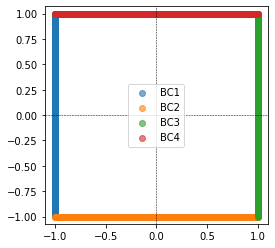

In [6]:
def plot_bc_collocs(bc_collocs):
    """Plots the boundary collocation points."""
    plt.figure(figsize=(4, 4))
    for i, colloc in enumerate(bc_collocs, start=1):
        plt.scatter(colloc[:, 0], colloc[:, 1], label=f'BC{i}', alpha=0.6)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
    plt.legend()
    plt.axis('equal')
    plt.show()
    
# only sample boundary once
BC1_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([-1,1]), Config.BS_BC))
BC1_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC2_colloc = jnp.array(sobol_sample(np.array([-1,-1]), np.array([1,-1]), Config.BS_BC))
BC2_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC3_colloc = jnp.array(sobol_sample(np.array([1,-1]), np.array([1,1]), Config.BS_BC))
BC3_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

BC4_colloc = jnp.array(sobol_sample(np.array([-1,1]), np.array([1,1]), Config.BS_BC))
BC4_data = jnp.zeros(Config.BS_BC).reshape(-1,1)

bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc, BC4_colloc]
bc_data = [BC1_data, BC2_data, BC3_data, BC4_data]

plot_bc_collocs(bc_collocs)

In [7]:
def visualize_nested_dict(d, indent=0):
    for key, value in d.items():
        print("  " * indent + f"- {key}")
        if isinstance(value, dict):  # Check if the value is another dictionary
            visualize_nested_dict(value, indent + 1)
            
visualize_nested_dict(variables)

- params
  - FourierFeats_0
    - B
    - bias
  - Dense_0
    - kernel
    - bias
  - Dense_1
    - kernel
    - bias
  - Dense_2
    - kernel
    - bias


In [8]:
N_collocs = collocs.shape[0] + len(bc_collocs) * bc_collocs[0].shape[0]
loc_w = [jnp.ones((collocs.shape[0], 1))] + [jnp.ones((bc_collocs[0].shape[0], 1)) for i in range(len(bc_collocs))]
len(loc_w) # attention weights for collocs and bc are independent

5

In [9]:
%%time
grid_adaption = {}

# train always on same colloc points
collocs = sample_collocs()
state = variables["params"]

losses = []
for i in (pbar:= tqdm(range(Config.EPOCHS))):    
    params = variables["params"]
    params, opt_state, loss, loc_w = train_step(params, collocs, bc_collocs, 
                                                 bc_data, opt_state, state, loc_w)
    variables = {'params': params}
    losses.append(loss)
    
    if i % 50 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .8f}")

    """
    if i % 500 == 0 and i > 1:
        # grid adaption
        updated_variables = model.apply(variables, collocs, Config.N_SPLINES_INIT, method=model.update_grids)
        variables = updated_variables.copy()
    """

Loss  571.19866943:   1%|          | 19/2500 [00:08<17:58,  2.30it/s] 


KeyboardInterrupt: 

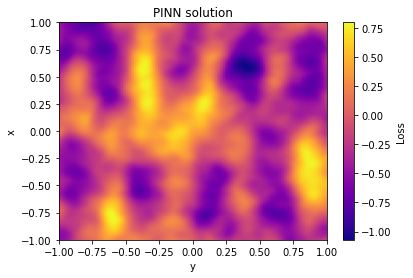

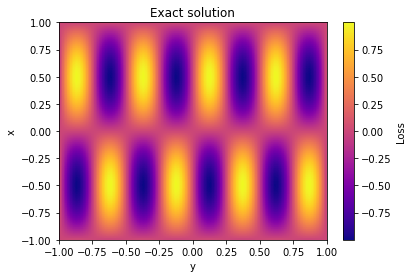

In [10]:
def plot_heatmap(arr, title):
    # Plot heatmap
    #plt.figure(figsize=(8, 6))
    plt.imshow(arr, extent=(Config.X_MIN, Config.X_MAX, 
                            Config.Y_MIN, Config.Y_MAX), origin="lower", aspect="auto", cmap="plasma")
    plt.colorbar(label="Loss")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.title(title)
    plt.show()

def u(vec_x):
    y = model.apply(variables, vec_x)
    return y

def exact_u(vec_x):
    y = jnp.sin(jnp.pi*vec_x[:, 0])*jnp.sin(4*jnp.pi*vec_x[:, 1])
    return y

def l2_error(results, true):
    err = jnp.sum((results - true)**2) / jnp.sum(true**2)
    err = jnp.sqrt(err)
    return err

N = 100 # NxN grid
x_grid = jnp.linspace(Config.X_MIN, Config.X_MAX, N)
y_grid = jnp.linspace(Config.Y_MIN, Config.Y_MAX, N)

# Create a meshgrid of x and t values
x_mesh, y_mesh = jnp.meshgrid(x_grid, y_grid, indexing="ij")
x_flat = x_mesh.flatten()
y_flat = y_mesh.flatten()
grid_points = jnp.stack((x_flat, y_flat), axis=-1)

results = u(grid_points).reshape(N, N)
loss = pde_loss(params, grid_points, state).reshape(N, N)
exact = exact_u(grid_points).reshape(N,N)

plot_heatmap(results,"PINN solution")
plot_heatmap(exact,"Exact solution")

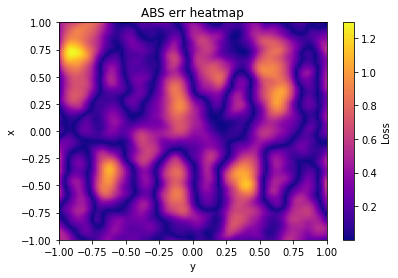

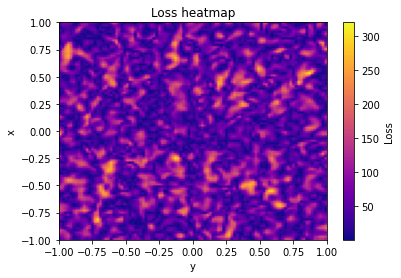

L2 error 83.6073%


Array(0.83607256, dtype=float32)

In [11]:
plot_heatmap(jnp.abs(results - exact),"ABS err heatmap")
plot_heatmap(jnp.abs(loss),"Loss heatmap")

l2_err = l2_error(results, exact)
print(f"L2 error {l2_err*100:.4f}%")
l2_err